In [1]:
from PIL import Image
import numpy as np
from skimage.util import view_as_blocks
import matplotlib.pyplot as plt

# CelebA dataset

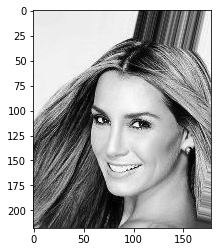

In [2]:
foldername = "./celeba/img_align_celeba/"
filename = "000001.jpg"

grayscale_image = Image.open(foldername+"/"+filename).convert('L')
array_image = np.asarray(grayscale_image)
plt.imshow(array_image, cmap="gray")
plt.show()

# Pooling

In [3]:
block_shape = (2, 2)
view = view_as_blocks(array_image, block_shape)
height, width, _, _ = view.shape

flatten = view.reshape(height, width, -1)
mean_view = np.mean(flatten, axis=2).astype('uint8')
max_view = np.max(flatten, axis=2).astype('uint8')

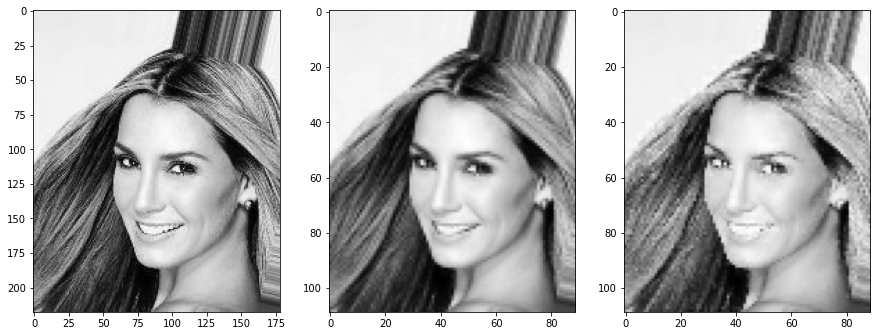

In [4]:
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].imshow(array_image, cmap="gray")
axarr[1].imshow(mean_view, cmap="gray")
axarr[2].imshow(max_view, cmap="gray")
plt.show()

The compressed array is saved in the original data type (uint8). Theoretical compression ratio: 4x.

# Vector Quantization

## baseline

In [5]:
from sklearn import cluster

In [6]:
n_clusters = 4
k_means = cluster.KMeans(n_clusters=n_clusters, n_init=4)
k_means.fit(array_image.reshape((-1, 1)))
cluster_centers = k_means.cluster_centers_.astype('uint8')
labels = k_means.labels_.astype('uint8')
compressed_array_image = cluster_centers[labels].reshape(array_image.shape)

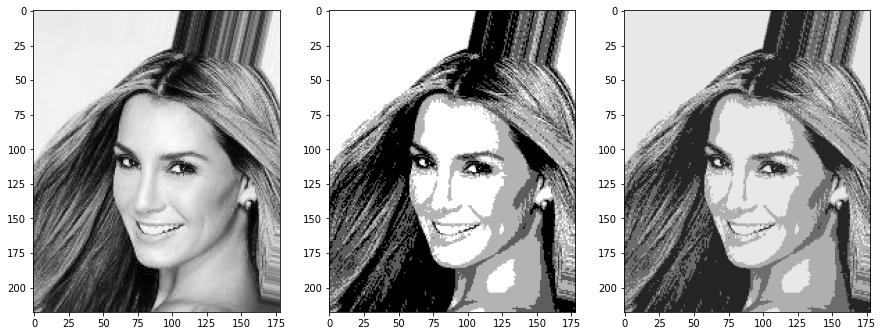

In [7]:
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].imshow(array_image, cmap="gray")
axarr[1].imshow(compressed_array_image, cmap="gray")
axarr[2].imshow(compressed_array_image, cmap="gray", vmin=array_image.min(), vmax=array_image.max())
plt.show()

Theoretical compression ratio: 4x (neglecting the memory size of the n_clusters and representing the elements in labels with only 2 bits).

## n_clusters

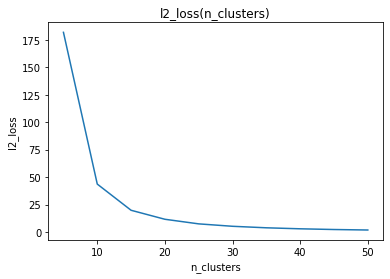

In [8]:
l2_loss_list = []
n_clusters_list = range(5, 55, 5)
for n_clusters in n_clusters_list:
    k_means = cluster.KMeans(n_clusters=n_clusters)
    k_means.fit(array_image.reshape((-1, 1)))
    compressed_array_image = k_means.cluster_centers_[k_means.labels_].reshape(array_image.shape)
    l2_loss = ((array_image - compressed_array_image)**2).mean()
    l2_loss_list.append(l2_loss)
    
plt.plot(n_clusters_list, l2_loss_list)
plt.title("l2_loss(n_clusters)")
plt.xlabel("n_clusters")
plt.ylabel("l2_loss")
plt.show()

## block size

In [9]:
block_shape = (2, 2)
view = view_as_blocks(array_image, block_shape)
flatten_view = view.reshape(view.shape[0], view.shape[1], -1)

In [10]:
n_clusters = 16
k_means = cluster.KMeans(n_clusters=n_clusters)
k_means.fit(flatten_view.reshape(-1, 4))
cluster_centers = k_means.cluster_centers_.astype('uint8')
labels = k_means.labels_.astype('uint8')
compressed_flatten_view = cluster_centers[labels].reshape(flatten_view.shape)
compressed_array_image = np.concatenate(np.concatenate(compressed_flatten_view.reshape(view.shape), axis=1), axis=1)

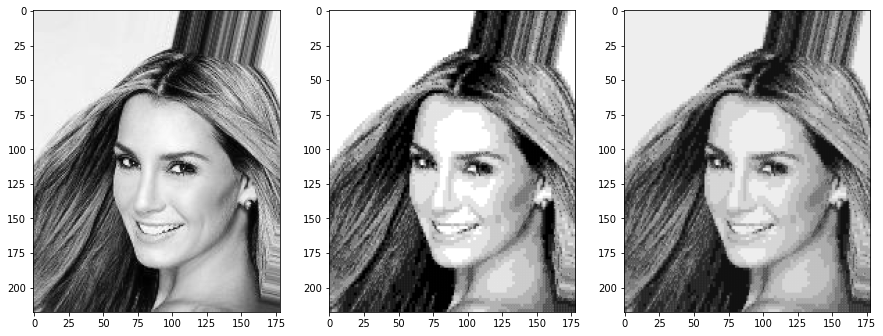

In [11]:
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].imshow(array_image, cmap="gray")
axarr[1].imshow(compressed_array_image, cmap="gray")
axarr[2].imshow(compressed_array_image, cmap="gray", vmin=array_image.min(), vmax=array_image.max())
plt.show()

Theoretical compression ratio: 8x (neglecting the memory size of the n_clusters and representing the elements in labels with only 4 bits).

# SVD

## baseline

In [12]:
k = 50
U, E, VT = np.linalg.svd(array_image, full_matrices=False)
compressed_array_image = np.uint8(np.matmul(np.matmul(U[:, :k], np.diag(E[:k])), VT[:k, :]))

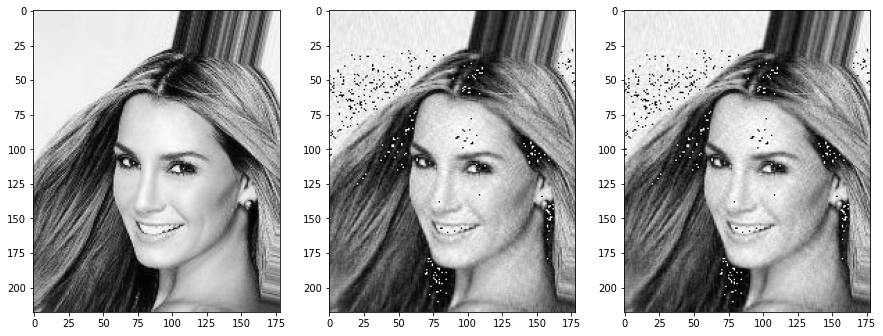

In [13]:
f, axarr = plt.subplots(1, 3, figsize=(15, 15))
axarr[0].imshow(array_image, cmap="gray")
axarr[1].imshow(compressed_array_image, cmap="gray")
axarr[2].imshow(compressed_array_image, cmap="gray", vmin=array_image.min(), vmax=array_image.max())
plt.show()

Theoretical compression ratio is: 1.96x. (saving only the reduced SVD decomposition). 

## number of singular values k

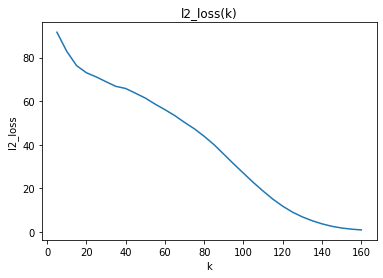

In [14]:
l2_loss_list = []
k_list = range(5, 165, 5)
for k in k_list:
    U, E, VT = np.linalg.svd(array_image, full_matrices=False)
    compressed_array_image = np.uint8(np.matmul(np.matmul(U[:, :k], np.diag(E[:k])), VT[:k, :]))
    l2_loss = ((array_image - compressed_array_image)**2).mean()
    l2_loss_list.append(l2_loss)
    
plt.plot(k_list, l2_loss_list)
plt.title("l2_loss(k)")
plt.xlabel("k")
plt.ylabel("l2_loss")
plt.show()